## 3.4使用PyTorch实现数据迁移实例
本节通过一个使用PyTorch实现数据迁移的实例，帮助大家加深对相关知识的理解

## 3.4.1 特征提取实例

特征提取示意图
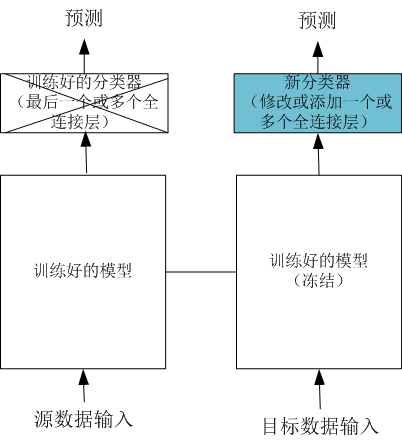

### 1.导入模块

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from datetime import datetime

### 2.加载数据
对应数据已下载在本地，故download=False。为适合预训练模型，这里增加一些预处理功能，如数据标准化，对图片进行裁剪等。

In [3]:
trans_train = transforms.Compose(
    [transforms.RandomResizedCrop(224),
     transforms.RandomHorizontalFlip(),     
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

trans_valid = transforms.Compose(
    [transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

#如果是linux环境,root的值改为root='./data'，其它不变
trainset = torchvision.datasets.CIFAR10(root='.\data', train=True,
                                        download=False, transform=trans_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='.\data', train=False,
                                       download=False, transform=trans_valid)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

可视化图像

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


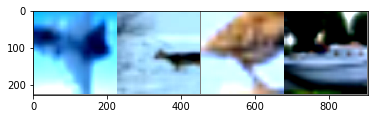

plane  deer  bird  ship


In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# 显示图像

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 随机获取部分训练数据
dataiter = iter(trainloader)
images, labels = dataiter.next()


# 显示图像
imshow(torchvision.utils.make_grid(images[:4]))
# 打印标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 3.下载预训练模型
这里将自动下载预训练模型，该模型网络架构为resnet18，且已经在ImageNet大数据集上训练好了，该数据集有1000类别。

In [4]:
# 使用预训练的模型
net = models.resnet18(pretrained=True)

### 4.冻结模型参数
这些参数被冻结，且在反向传播时，将不会更新。

In [5]:
# Freeze model weights
for param in net.parameters():
    param.requires_grad = False

### 5.修改最后一层的输出类别数
原来输出为512x1000，我们把输出改为512x10，我们新数据集有10个类别。

In [6]:
# 将最后的全连接层改成十分类
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
net.fc = nn.Linear(512, 10)
#net = torch.nn.DataParallel(net)

### 6.查看冻结前后的参数情况
使用如下代码查看冻结前后的参数情况：

In [7]:
# 查看总参数及训练参数
total_params = sum(p.numel() for p in net.parameters())
print('总参数个数:{}'.format(total_params))
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('需训练参数个数:{}'.format(total_trainable_params))


总参数个数:11181642
需训练参数个数:5130


由运行结果可知，如果不冻结，需要更新的参数会非常多，冻结后，只需要更新全连接层的相关参数。

### 7.定义损失函数及优化器
定义损失函数及优化器的代码如下所示：

In [8]:
net=net.to(device)

In [9]:
#定义评估指标
def get_acc(output, label):
    total = output.shape[0]
    _, pred_label = output.max(1)
    num_correct = (pred_label == label).sum().item()
    return num_correct / total


In [10]:
#定义损失函数
criterion = nn.CrossEntropyLoss()
#只需要优化最后一层参数
optimizer = torch.optim.SGD(net.fc.parameters(), lr=1e-3, weight_decay=1e-3,momentum=0.9)

### 8.训练及验证模型
训练及验证模型的代码如下所示：

In [11]:
def train(net, train_data, valid_data, num_epochs, optimizer, criterion):
   
    prev_time = datetime.now()
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        net = net.train()
        for im, label in train_data:
            im = im.to(device)  # (bs, 3, h, w)
            label = label.to(device) # (bs, h, w)
            # forward
            output = net(im)
            loss = criterion(output, label)
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += get_acc(output, label)

        cur_time = datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_loss = 0
            valid_acc = 0
            net = net.eval()
            for im, label in valid_data:
                im = im.to(device)  # (bs, 3, h, w)
                label = label.to(device) # (bs, h, w)
                output = net(im)
                loss = criterion(output, label)
                valid_loss += loss.item()
                valid_acc += get_acc(output, label)
            epoch_str = (
                "Epoch %d. Train Loss: %f, Train Acc: %f, Valid Loss: %f, Valid Acc: %f, "
                % (epoch, train_loss / len(train_data),
                   train_acc / len(train_data), valid_loss / len(valid_data),
                   valid_acc / len(valid_data)))
        else:
            epoch_str = ("Epoch %d. Train Loss: %f, Train Acc: %f, " %
                         (epoch, train_loss / len(train_data),
                          train_acc / len(train_data)))
        prev_time = cur_time
        print(epoch_str + time_str)

In [12]:
train(net, trainloader, testloader, 20, optimizer, criterion)

Epoch 0. Train Loss: 1.470662, Train Acc: 0.501299, Valid Loss: 0.913619, Valid Acc: 0.704120, Time 00:02:45
Epoch 1. Train Loss: 1.218964, Train Acc: 0.579264, Valid Loss: 0.821985, Valid Acc: 0.726214, Time 00:03:19
Epoch 2. Train Loss: 1.176578, Train Acc: 0.592571, Valid Loss: 0.788861, Valid Acc: 0.736664, Time 00:03:19
Epoch 3. Train Loss: 1.154606, Train Acc: 0.597706, Valid Loss: 0.779969, Valid Acc: 0.735271, Time 00:03:19
Epoch 4. Train Loss: 1.144575, Train Acc: 0.602402, Valid Loss: 0.750391, Valid Acc: 0.748308, Time 00:03:19
Epoch 5. Train Loss: 1.135708, Train Acc: 0.601183, Valid Loss: 0.754318, Valid Acc: 0.745123, Time 00:03:20
Epoch 6. Train Loss: 1.128625, Train Acc: 0.605738, Valid Loss: 0.748776, Valid Acc: 0.748905, Time 00:03:21
Epoch 7. Train Loss: 1.121514, Train Acc: 0.607956, Valid Loss: 0.738947, Valid Acc: 0.746517, Time 00:03:22
Epoch 8. Train Loss: 1.125171, Train Acc: 0.608636, Valid Loss: 0.731027, Valid Acc: 0.749900, Time 00:03:22
Epoch 9. Train Loss

从上述结果可以看出，精确率达到75%左右。这个精度虽然有比较大的提升，但还不够理想，下节我们将采用微调+数据增强的方法，精度将提升到95%！